# Harris-Stephens corner detection

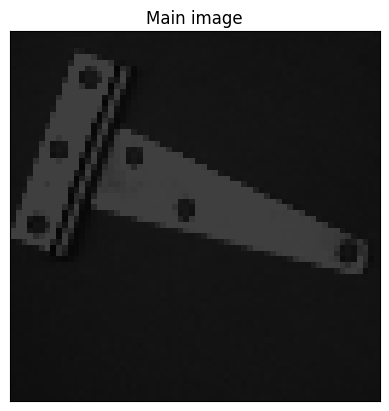

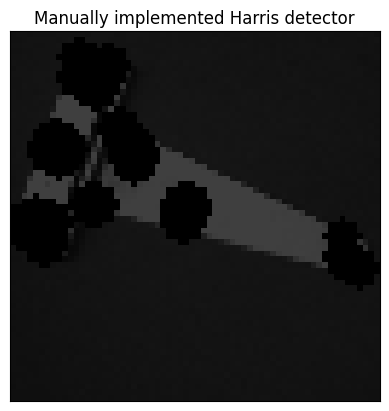

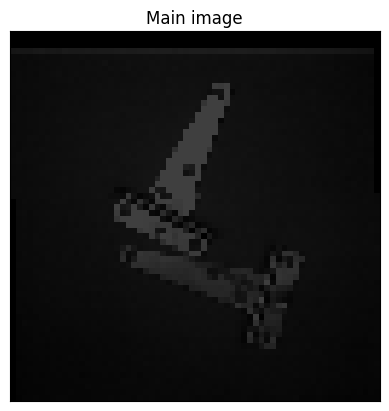

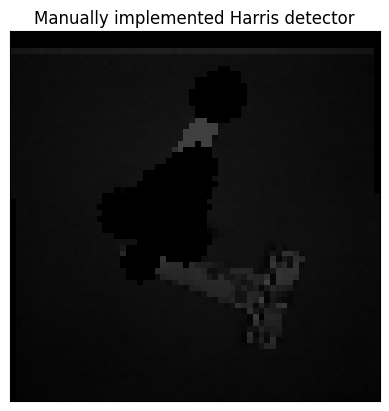

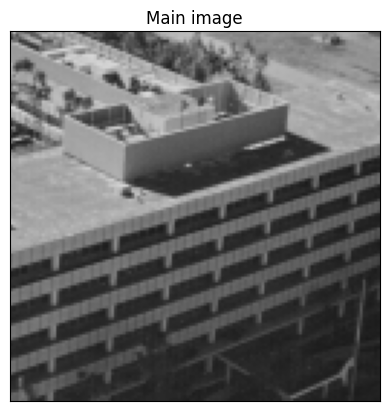

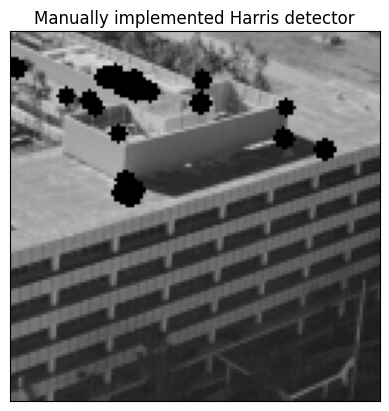

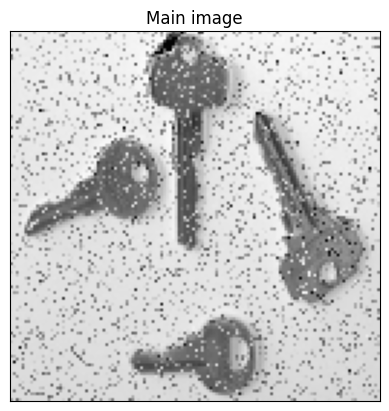

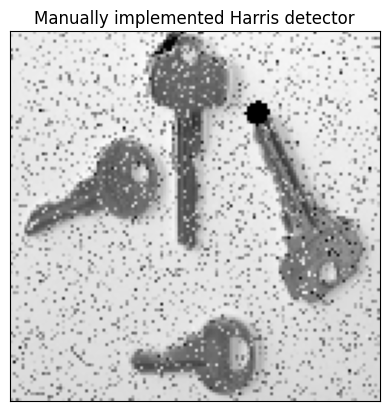

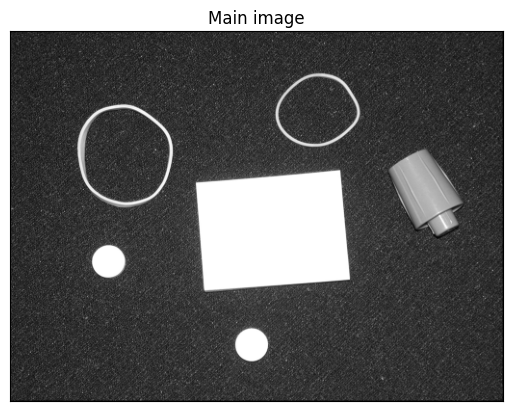

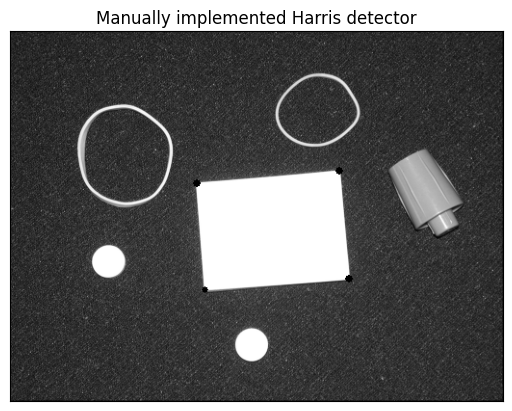

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def Harris_Stephens(image, window_size=3, k=0.04, threshold=0.01):
    # Compute image derivatives
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=window_size)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=window_size)

    # Compute the products of derivatives at every pixel
    Ixx = dx * dx
    Ixy = dx * dy
    Iyy = dy * dy

    # Compute the sums of the products of derivatives at each pixel
    Sxx = cv2.boxFilter(Ixx, cv2.CV_64F, (window_size, window_size))
    Sxy = cv2.boxFilter(Ixy, cv2.CV_64F, (window_size, window_size))
    Syy = cv2.boxFilter(Iyy, cv2.CV_64F, (window_size, window_size))

    # Compute the determinant and trace of the matrix M
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy

    # Compute the Harris response
    harris_response = det_M - k * (trace_M ** 2)

    # Threshold the response to obtain corner points
    corners = np.argwhere(harris_response > threshold * harris_response.max())

    return corners

images = ["hinge.pnm","hinges.pnm","building.pnm","keys.pnm","pillsetc.pnm"]

for image in images:
# Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Compute corners
    corners = Harris_Stephens(img,3, 0.04, 0.30)


    plt.figure("Main image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Main image")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()
    # Draw corners on image
    for corner in corners:
        x, y = corner
        cv2.circle(img, (y, x), 3, (0, 255, 0), -1)

    # Display image
    plt.figure("Manually implemented Harris detector")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Manually implemented Harris detector")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()


# Canny edge detector

In [ ]:
import numpy as np
import cv2

def Canny_edge_detector(image, low_threshold=100, high_threshold=200):
    # Compute image derivatives
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1)

    # Compute magnitude and direction of gradient
    mag = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    # Convert angle to degrees and shift to positive values
    angle = np.degrees(angle) % 180

    # Perform non-maximum suppression
    suppressed_mag = np.zeros_like(mag)
    for i in range(1, mag.shape[0]-1):
        for j in range(1, mag.shape[1]-1):
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                if (mag[i,j] >= mag[i,j+1]) and (mag[i,j] >= mag[i,j-1]):
                    suppressed_mag[i,j] = mag[i,j]
            elif (22.5 <= angle[i,j] < 67.5):
                if (mag[i,j] >= mag[i+1,j+1]) and (mag[i,j] >= mag[i-1,j-1]):
                    suppressed_mag[i,j] = mag[i,j]
            elif (67.5 <= angle[i,j] < 112.5):
                if (mag[i,j] >= mag[i+1,j]) and (mag[i,j] >= mag[i-1,j]):
                    suppressed_mag[i,j] = mag[i,j]
            else:
                if (mag[i,j] >= mag[i-1,j+1]) and (mag[i,j] >= mag[i+1,j-1]):
                    suppressed_mag[i,j] = mag[i,j]

    # Perform double thresholding
    edges = np.zeros_like(suppressed_mag)
    weak = 50
    strong = 255
    strong_i, strong_j = np.where(suppressed_mag >= high_threshold)
    weak_i, weak_j = np.where((suppressed_mag >= low_threshold) & (suppressed_mag < high_threshold))
    edges[strong_i, strong_j] = strong
    edges[weak_i, weak_j] = weak

    # Perform edge tracking by hysteresis
    for i in range(1, edges.shape[0]-1):
        for j in range(1, edges.shape[1]-1):
            if edges[i,j] == weak:
                if (edges[i-1,j-1] == strong) or (edges[i-1,j] == strong) or (edges[i-1,j+1] == strong) or (edges[i,j-1] == strong) or (edges[i,j+1] == strong) or (edges[i+1,j-1] == strong) or (edges[i+1,j] == strong) or (edges[i+1,j+1] == strong):
                    edges[i,j] = strong
                else:
                    edges[i,j] = 0

    return edges

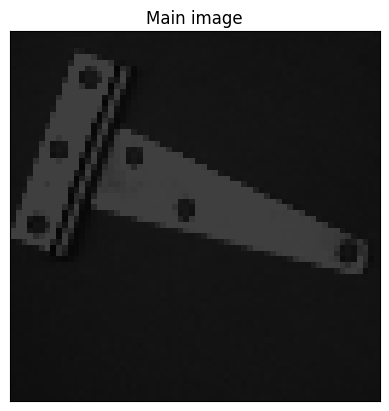

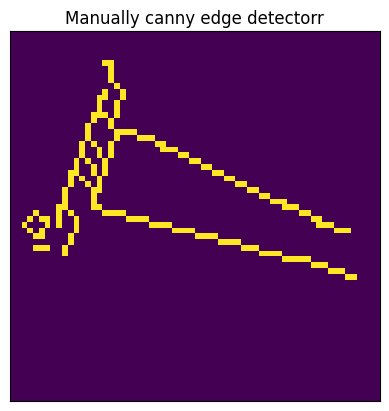

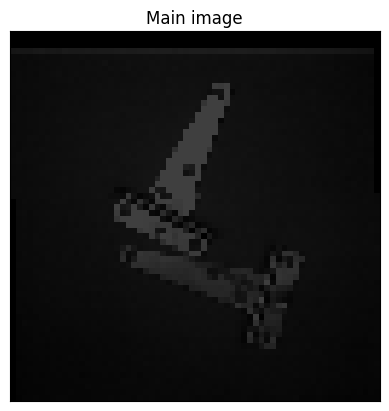

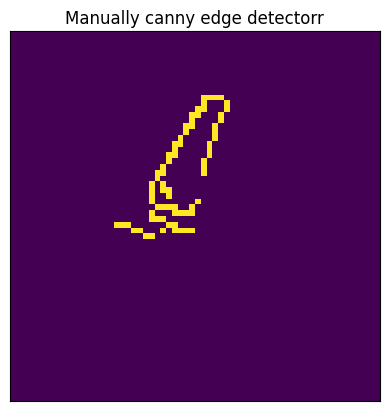

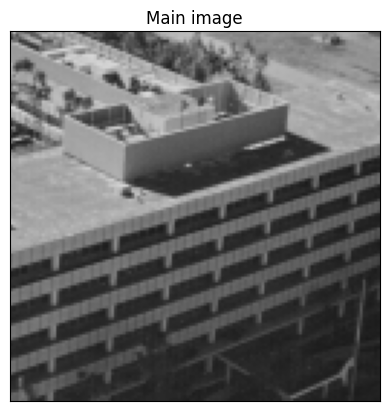

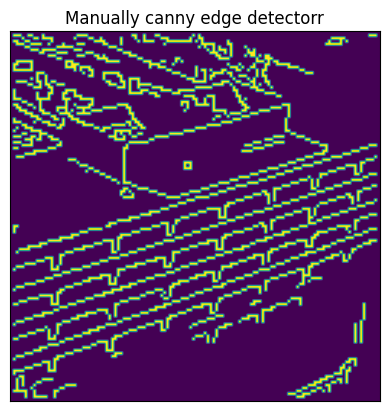

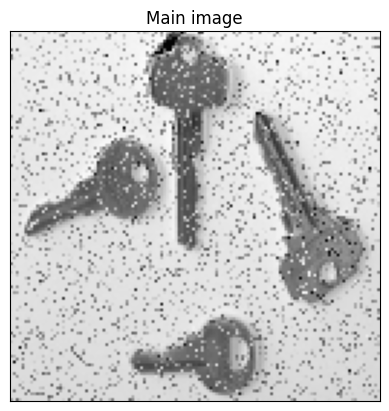

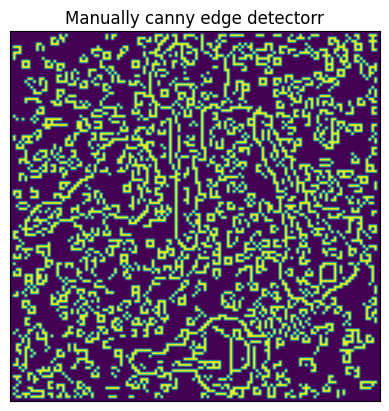

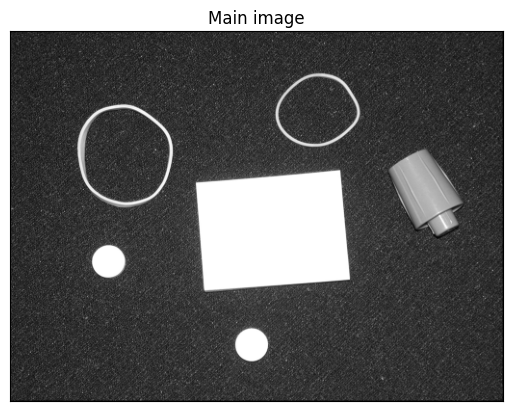

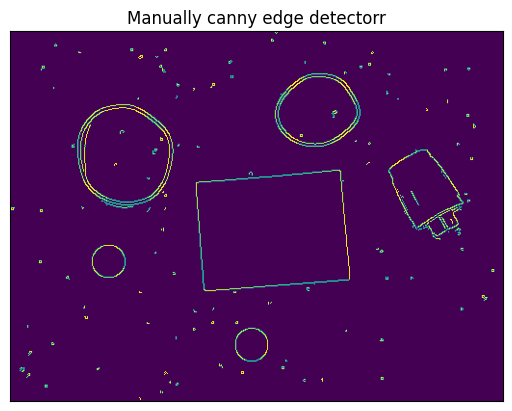

In [ ]:
images = ["hinge.pnm","hinges.pnm","building.pnm","keys.pnm","pillsetc.pnm"]

for image in images:
# Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    plt.figure("Main image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Main image")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()

    edges = Canny_edge_detector(img)

    # Display image
    plt.figure("Manually implemented canny edge detector")
    plt.imshow(edges), plt.title("Manually canny edge detectorr")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()



# Hough transform

In [ ]:
import numpy as np
import cv2

def hough_transform(image):
    # Compute gradient magnitude and direction
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude, direction = cv2.cartToPolar(grad_x, grad_y)
    direction_quantized = np.round(direction / np.pi * 180 / 4) % 180
    direction_quantized[direction_quantized == 8] = 0

    # Build Hough transform space
    rows, cols = image.shape
    max_distance = int(np.ceil(np.sqrt(rows**2 + cols**2)))
    accumulator = np.zeros((max_distance*2, 180//4))
    y_idxs, x_idxs = np.nonzero(image)
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for theta_idx in range(180//4):
            theta = np.deg2rad(theta_idx * 4)
            rho = int(np.round(x * np.cos(theta) + y * np.sin(theta))) + max_distance
            accumulator[rho, theta_idx] += 1

    return accumulator, direction_quantized

def back_projection(image, accumulator, threshold):
    # Identify edge points that belong to straight lines
    rows, cols = image.shape
    y_idxs, x_idxs = np.nonzero(image)
    line_idxs = []
    #print(x_idxs)
    #print(y_idxs)
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        #print("theta")
        for theta_idx in range(180//4):
            theta = np.deg2rad(theta_idx * 4)
            rho = int(np.round(x * np.cos(theta) + y * np.sin(theta))) + accumulator.shape[0] // 2
            #print(accumulator[rho, theta_idx])

            if accumulator[rho, theta_idx] >= threshold:
                line_idxs.append((rho, theta_idx))
    #print("line_idxs")
    #print(line_idxs)


    # Fit eigenvector lines to each set of edge points
    lines = []
    for idxs in line_idxs:
        rho = idxs[0] - accumulator.shape[0] // 2
        theta = np.deg2rad(idxs[1] * 4)
        A = np.cos(theta)
        B = np.sin(theta)
        x0 = A * rho
        y0 = B * rho
        u = -B
        v = A
        line_length = np.sum((x_idxs * u + y_idxs * v)**2) / np.sum(u**2 + v**2)
        lines.append((x0, y0, u, v, line_length))

    return lines

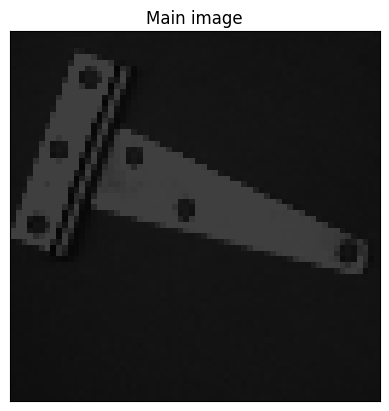

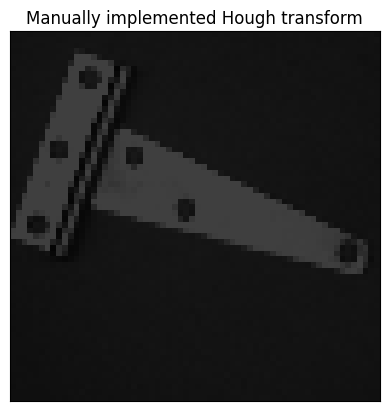

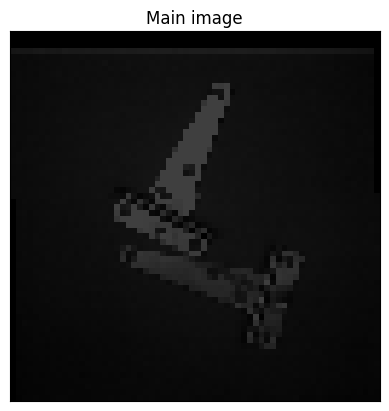

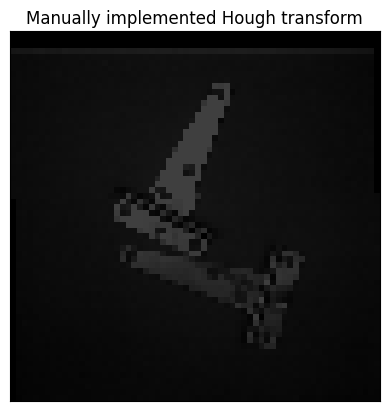

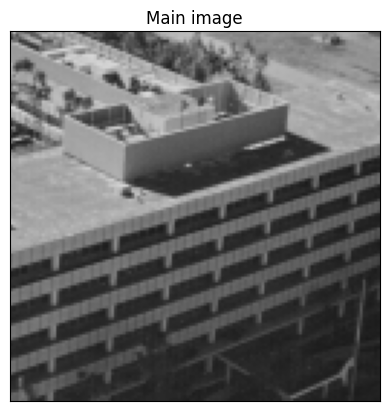

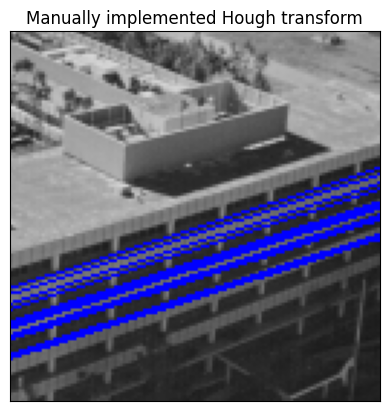

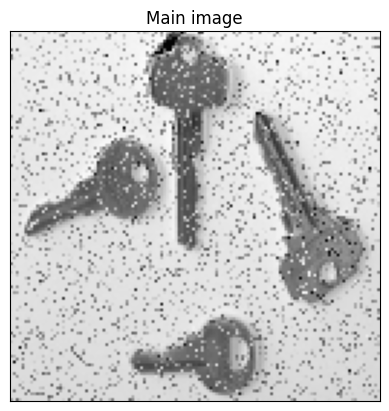

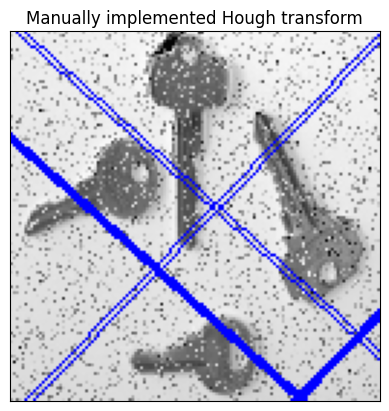

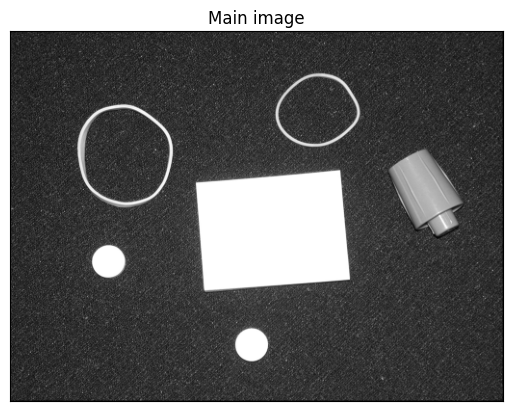

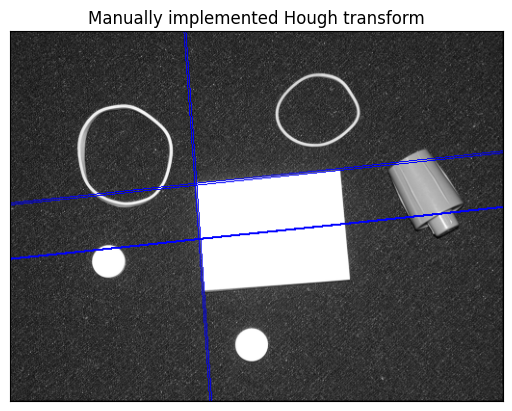

In [ ]:
images = ["hinge.pnm","hinges.pnm","building.pnm","keys.pnm","pillsetc.pnm"]

for image in images:

    # Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    plt.figure("Main image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Main image")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()

    # Compute edges
    edges = Canny_edge_detector(img, 100, 200)
    # Compute Hough transform
    accumulator, direction = hough_transform(edges)

    # Identify straight lines using back-projection
    lines = back_projection(edges, accumulator, threshold=64)

    # Draw lines on image
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    #print(lines)
    for line in lines:
        x0, y0, u, v, line_length = line
        x1 = int(x0 + line_length * u)
        y1 = int(y0 + line_length * v)
        x2 = int(x0 - line_length * u)
        y2 = int(y0 - line_length * v)
        cv2.line(color_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Display image
    plt.figure("Manually implemented Harris detector")
    plt.imshow(color_img), plt.title("Manually implemented Hough transform")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()

# RANSAC algorithm

In [ ]:
import random

def ransac_line_detection(points, n_iterations=100, threshold_distance=0.1):

    best_line = None
    best_line_inliers = []
    n_points = points.shape[0]

    for i in range(n_iterations):
        # Randomly select two points from the set of edge points
        sample_indices = random.sample(range(n_points), 2)
        p1, p2 = points[sample_indices[0]], points[sample_indices[1]]

        # Compute the parameters of the line passing through the two points
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        c = p2[0]*p1[1] - p1[0]*p2[1]

        # Find the inliers that are within the threshold distance from the line
        inliers = []
        for j in range(n_points):
            if j not in sample_indices:
                point = points[j]
                distance = abs(a*point[0] + b*point[1] + c) / np.sqrt(a**2 + b**2)
                if distance <= threshold_distance:
                    inliers.append(j)

        # If the number of inliers is greater than the current best, update the best line
        if len(inliers) > len(best_line_inliers):
            best_line_inliers = inliers
            x1, y1 = points[sample_indices[0]]
            x2, y2 = points[sample_indices[1]]
            best_line = ((x1, y1), (x2, y2))

    return best_line

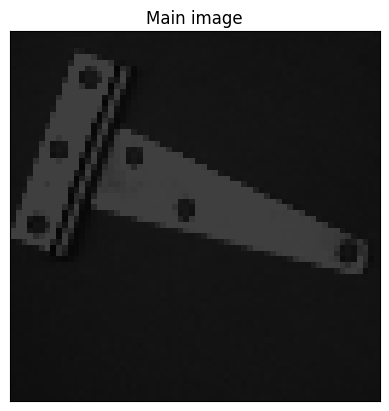

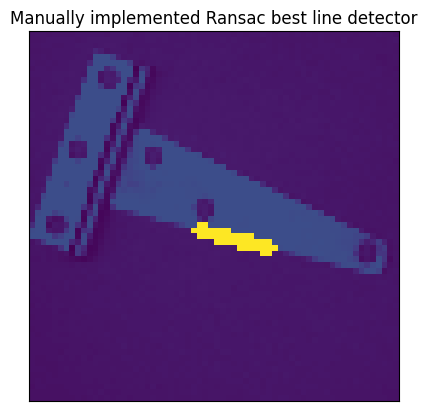

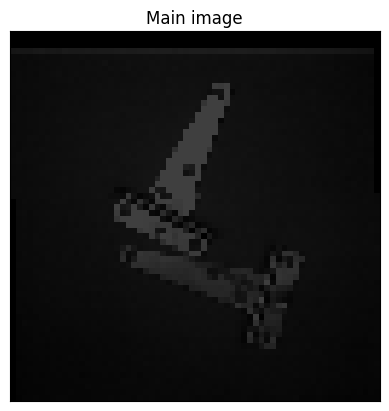

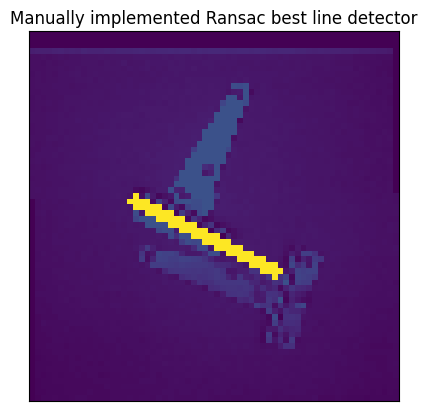

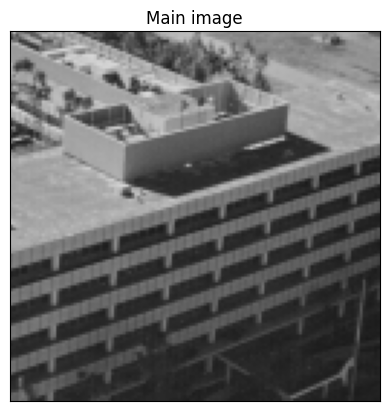

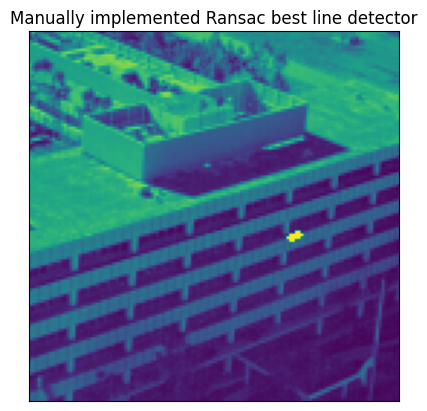

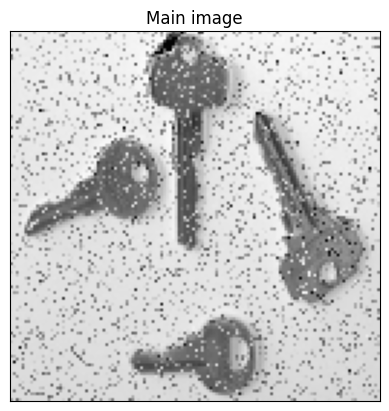

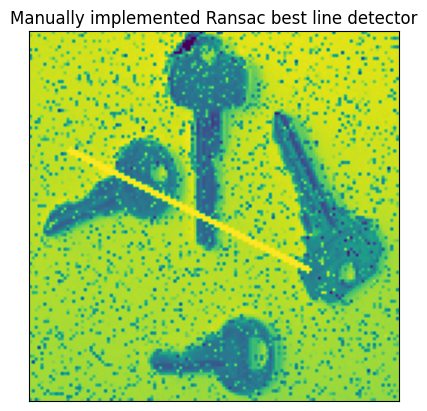

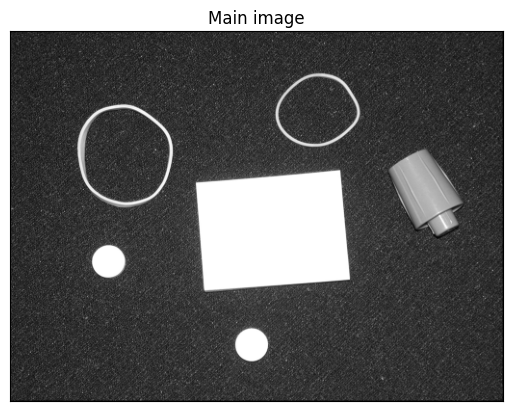

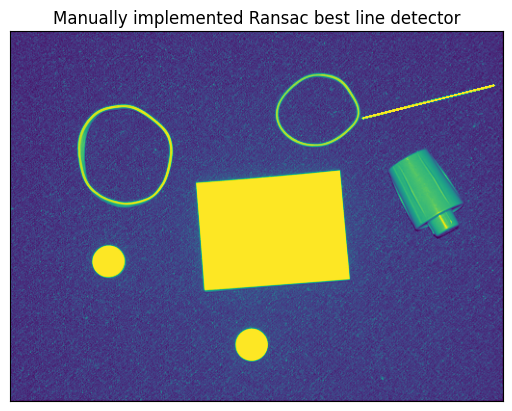

In [ ]:
images = ["hinge.pnm","hinges.pnm","building.pnm","keys.pnm","pillsetc.pnm"]

for image in images:

    # Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    plt.figure("Main image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Main image")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()

    # Compute edges
    edges = cv2.Canny(img, 50, 200)

    # Find the edge points
    y_indices, x_indices = np.where(edges != 0)
    points = np.column_stack((x_indices, y_indices))


    # Detect the line using the RANSAC algorithm
    line = ransac_line_detection(points,n_iterations=500, threshold_distance=0.5)

    # Draw the line on the image
    cv2.line(img, line[0], line[1], (255, 0, 0), 2)

    # Display image
    plt.figure("Manually implemented Harris detector")
    plt.imshow(img), plt.title("Manually implemented Ransac best line detector")
    plt.xticks([]), plt.yticks([])
    plt.show()
    print()